In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.datasets as dset
import numpy as np
import cv2

from center_loss import CenterLoss
from frw import L2_penalty_with_constant
from reid_model import ReID_Net
from datasets import CUHK03, Market1501, VIPeR, CUHK01
from custom_transforms import RandomTranslation
from evaluation import pairwise_squared_euclidian_distance, generate_split_cuhk03, get_topk_results, apk, mapk, generate_query, calculate_mAP, get_gallery_for_cross_camera_search
import time
import shutil

## Avaliação do modelo treinado

In [3]:
!ls trained_models

cuhk01_finetuned.pth  market1501_trained.pth	   viper_finetuned.pth
cuhk03_trained.pth    transfer_learning_model.pth  viper_transfer.pth


In [4]:
model = ReID_Net.from_checkpoint('trained_models/cuhk01_finetuned.pth')
model = model.cuda()
model = model.eval()

In [5]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),                    # = transpose(0,3,1,2), range [0, 1]
    transforms.Lambda(lambda t: t/0.5 - 1)    # = range [-1, 1]
])

dataset = VIPeR('../reid/datasets/cuhk01_test_correct.npz', train=False, test=True,
                 transform=data_transforms)

dloader = DataLoader(dataset, batch_size=100, shuffle=False)

In [6]:
X_querygal = dataset.X
y_querygal = dataset.y
cam_ids = dataset.cam_ids

print('Número de identidades para teste: ', len(np.unique(y_querygal)))
print('Número de câmeras distintas: ', len(np.unique(cam_ids)))

Número de identidades para teste:  486
Número de câmeras distintas:  2


## Conceito de split:
É usado  o método de 'cross-camera search': uma câmera é usada pra Query (consulta) e a(s) outra(s) para Gallery.
Para cada identidade no conjunto de Query (consulta), é escolhida aleatoriamente uma imagem de cada pessoa no conjunto Query e 1 imagem da mesma identidade das câmeras da Galeria.

Exemplo de split:

In [7]:
query_indices_by_cam = generate_query(y_querygal, cam_ids)

for cam, indices in query_indices_by_cam.items():
    print('Câmera:',cam)
    print('Índices para query/gallery ({}): {}'.format(len(indices), indices))
    print()

Câmera: 0
Índices para query/gallery (486): [0, 4, 8, 13, 16, 21, 25, 29, 32, 36, 40, 44, 49, 53, 57, 61, 65, 69, 73, 76, 80, 85, 89, 92, 96, 100, 105, 108, 113, 116, 120, 125, 129, 133, 137, 141, 145, 148, 152, 157, 161, 164, 169, 173, 176, 180, 185, 189, 192, 197, 200, 204, 208, 212, 217, 221, 224, 229, 233, 236, 240, 244, 249, 252, 256, 260, 264, 269, 273, 276, 281, 284, 288, 292, 297, 301, 305, 308, 313, 317, 321, 324, 329, 332, 337, 341, 345, 349, 353, 357, 361, 364, 368, 372, 376, 381, 384, 389, 392, 396, 401, 405, 408, 413, 416, 420, 425, 428, 433, 436, 441, 445, 449, 452, 457, 460, 465, 468, 473, 477, 480, 484, 488, 493, 497, 500, 505, 508, 513, 516, 521, 524, 529, 533, 537, 540, 544, 549, 552, 557, 561, 564, 568, 573, 577, 580, 584, 589, 593, 596, 601, 604, 608, 612, 617, 620, 624, 628, 633, 637, 640, 645, 649, 652, 657, 660, 664, 669, 672, 676, 681, 685, 689, 692, 697, 701, 705, 708, 713, 717, 720, 724, 728, 732, 736, 740, 744, 749, 752, 757, 760, 764, 768, 773, 776, 781, 784

## Extraindo as features do conjunto de Query e Gallery

In [8]:
querygal_features = []

model = model.cuda()
model.eval()

for X, y in dloader:
    X = Variable(X.cuda(), volatile=True)
    
    batch_features = model.get_embeddings(X)
    querygal_features.append(batch_features.data.cpu())
    
querygal_features = torch.cat(querygal_features, dim=0)

In [9]:
print(querygal_features.size())

torch.Size([1944, 512])


In [10]:
distances = pairwise_squared_euclidian_distance(querygal_features, querygal_features)
print(distances.size())

torch.Size([1944, 1944])


In [11]:
# Ids de do conjunto Query+Gallery em ordem crescente de distância

querygal_split = {
    'query': np.array(query_indices_by_cam[0], dtype=np.intp),
    'gallery': np.array(query_indices_by_cam[1], dtype=np.intp)
}
gallery_indices = querygal_split['gallery']

rankings = gallery_indices[get_topk_results(distances, 10, querygal_split).numpy()]
print(rankings[:10])
print('...')
print(rankings.shape)

[[   2   67   31  243   83   18  919   95 1823  702]
 [   7 1467 1307  679  394  831  131  511  683  599]
 [  27   10  430 1890 1935 1843 1451 1343 1775  683]
 [  15   58 1162  371 1239  122  867 1395 1307 1135]
 [  18   67 1375 1899  158   78 1411 1319  919 1827]
 [   2   22   87 1823   67 1814 1838  919  595  907]
 [  27 1775   10 1451 1935 1890  430 1186 1546 1343]
 [  31  907   95 1414 1654 1411 1319  278 1814  919]
 [  34  378 1923  118 1778  358  143  599 1366   70]
 [  39  619  575  111   58  207    7  166  542 1034]]
...
(486, 10)


### Visualizando um rank-5

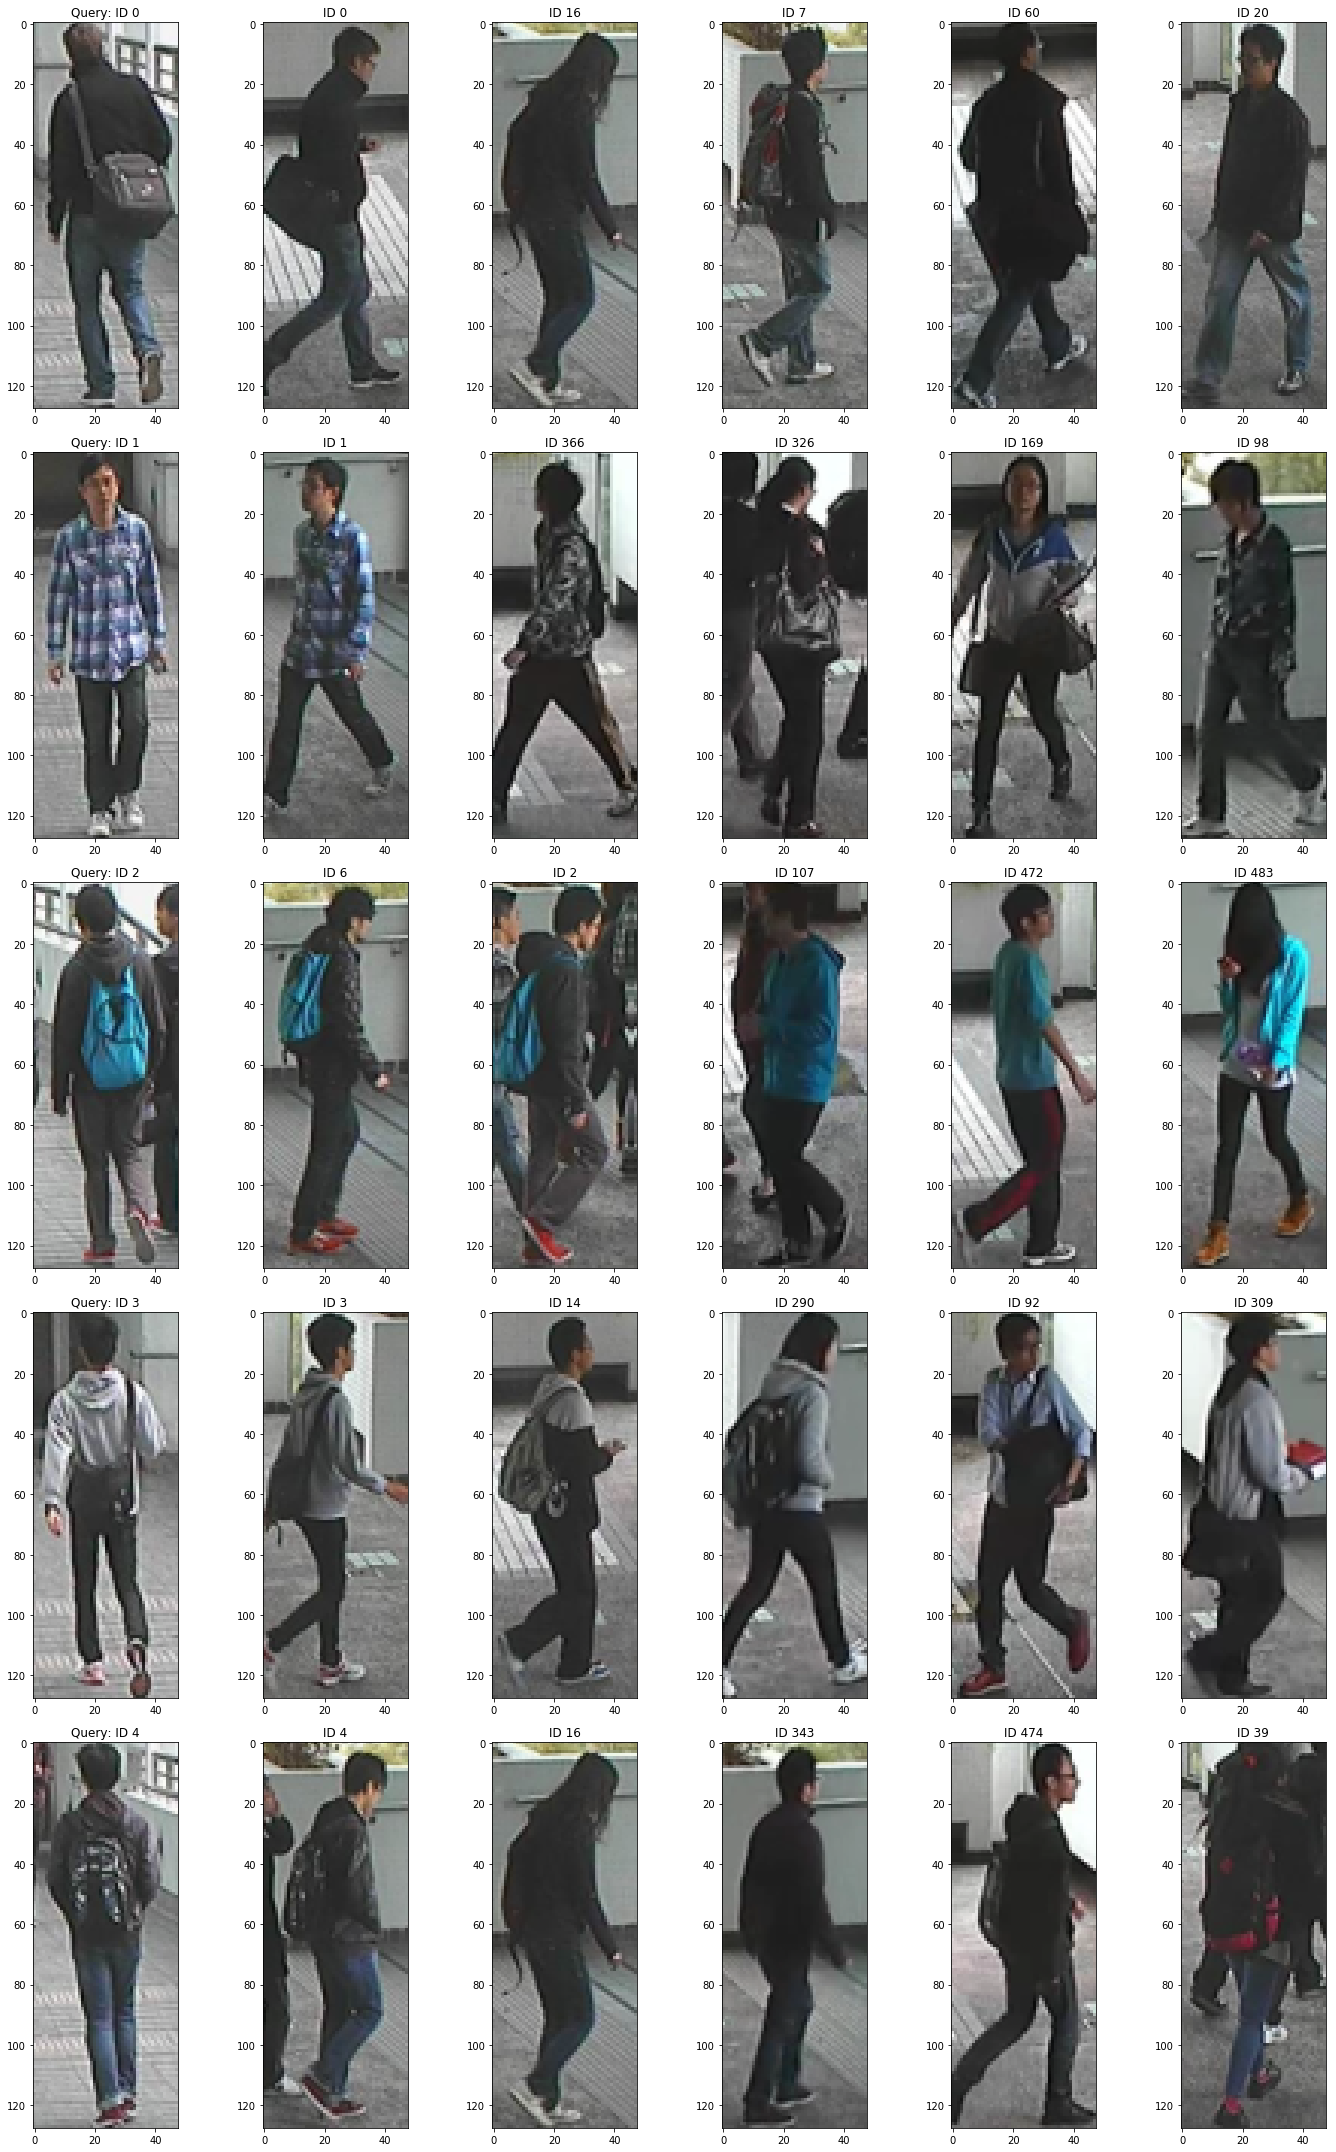

In [12]:
# Visualizando alguns rankings:
K = 5
N_cols = K+1

offset = 0

plt.figure(figsize=(20, 30))
for j in range(5):
    q_indice = querygal_split['query'][offset+j]
    #print(q_indice)
    ranking = rankings[offset+j, :K]
    #print(ranking)
    
    plt.subplot(5, K+1, (j*N_cols)+1)
    plt.imshow(X_querygal[q_indice])
    plt.title('Query: ID {}'.format(y_querygal[q_indice]))
    
    for i in range(K):
        plt.subplot(5, N_cols, (j*N_cols)+i+2)
        plt.imshow(X_querygal[ranking[i]])
        plt.title('ID {}'.format(y_querygal[ranking[i]]))
        
    plt.tight_layout()

### Visualizando um rank-10

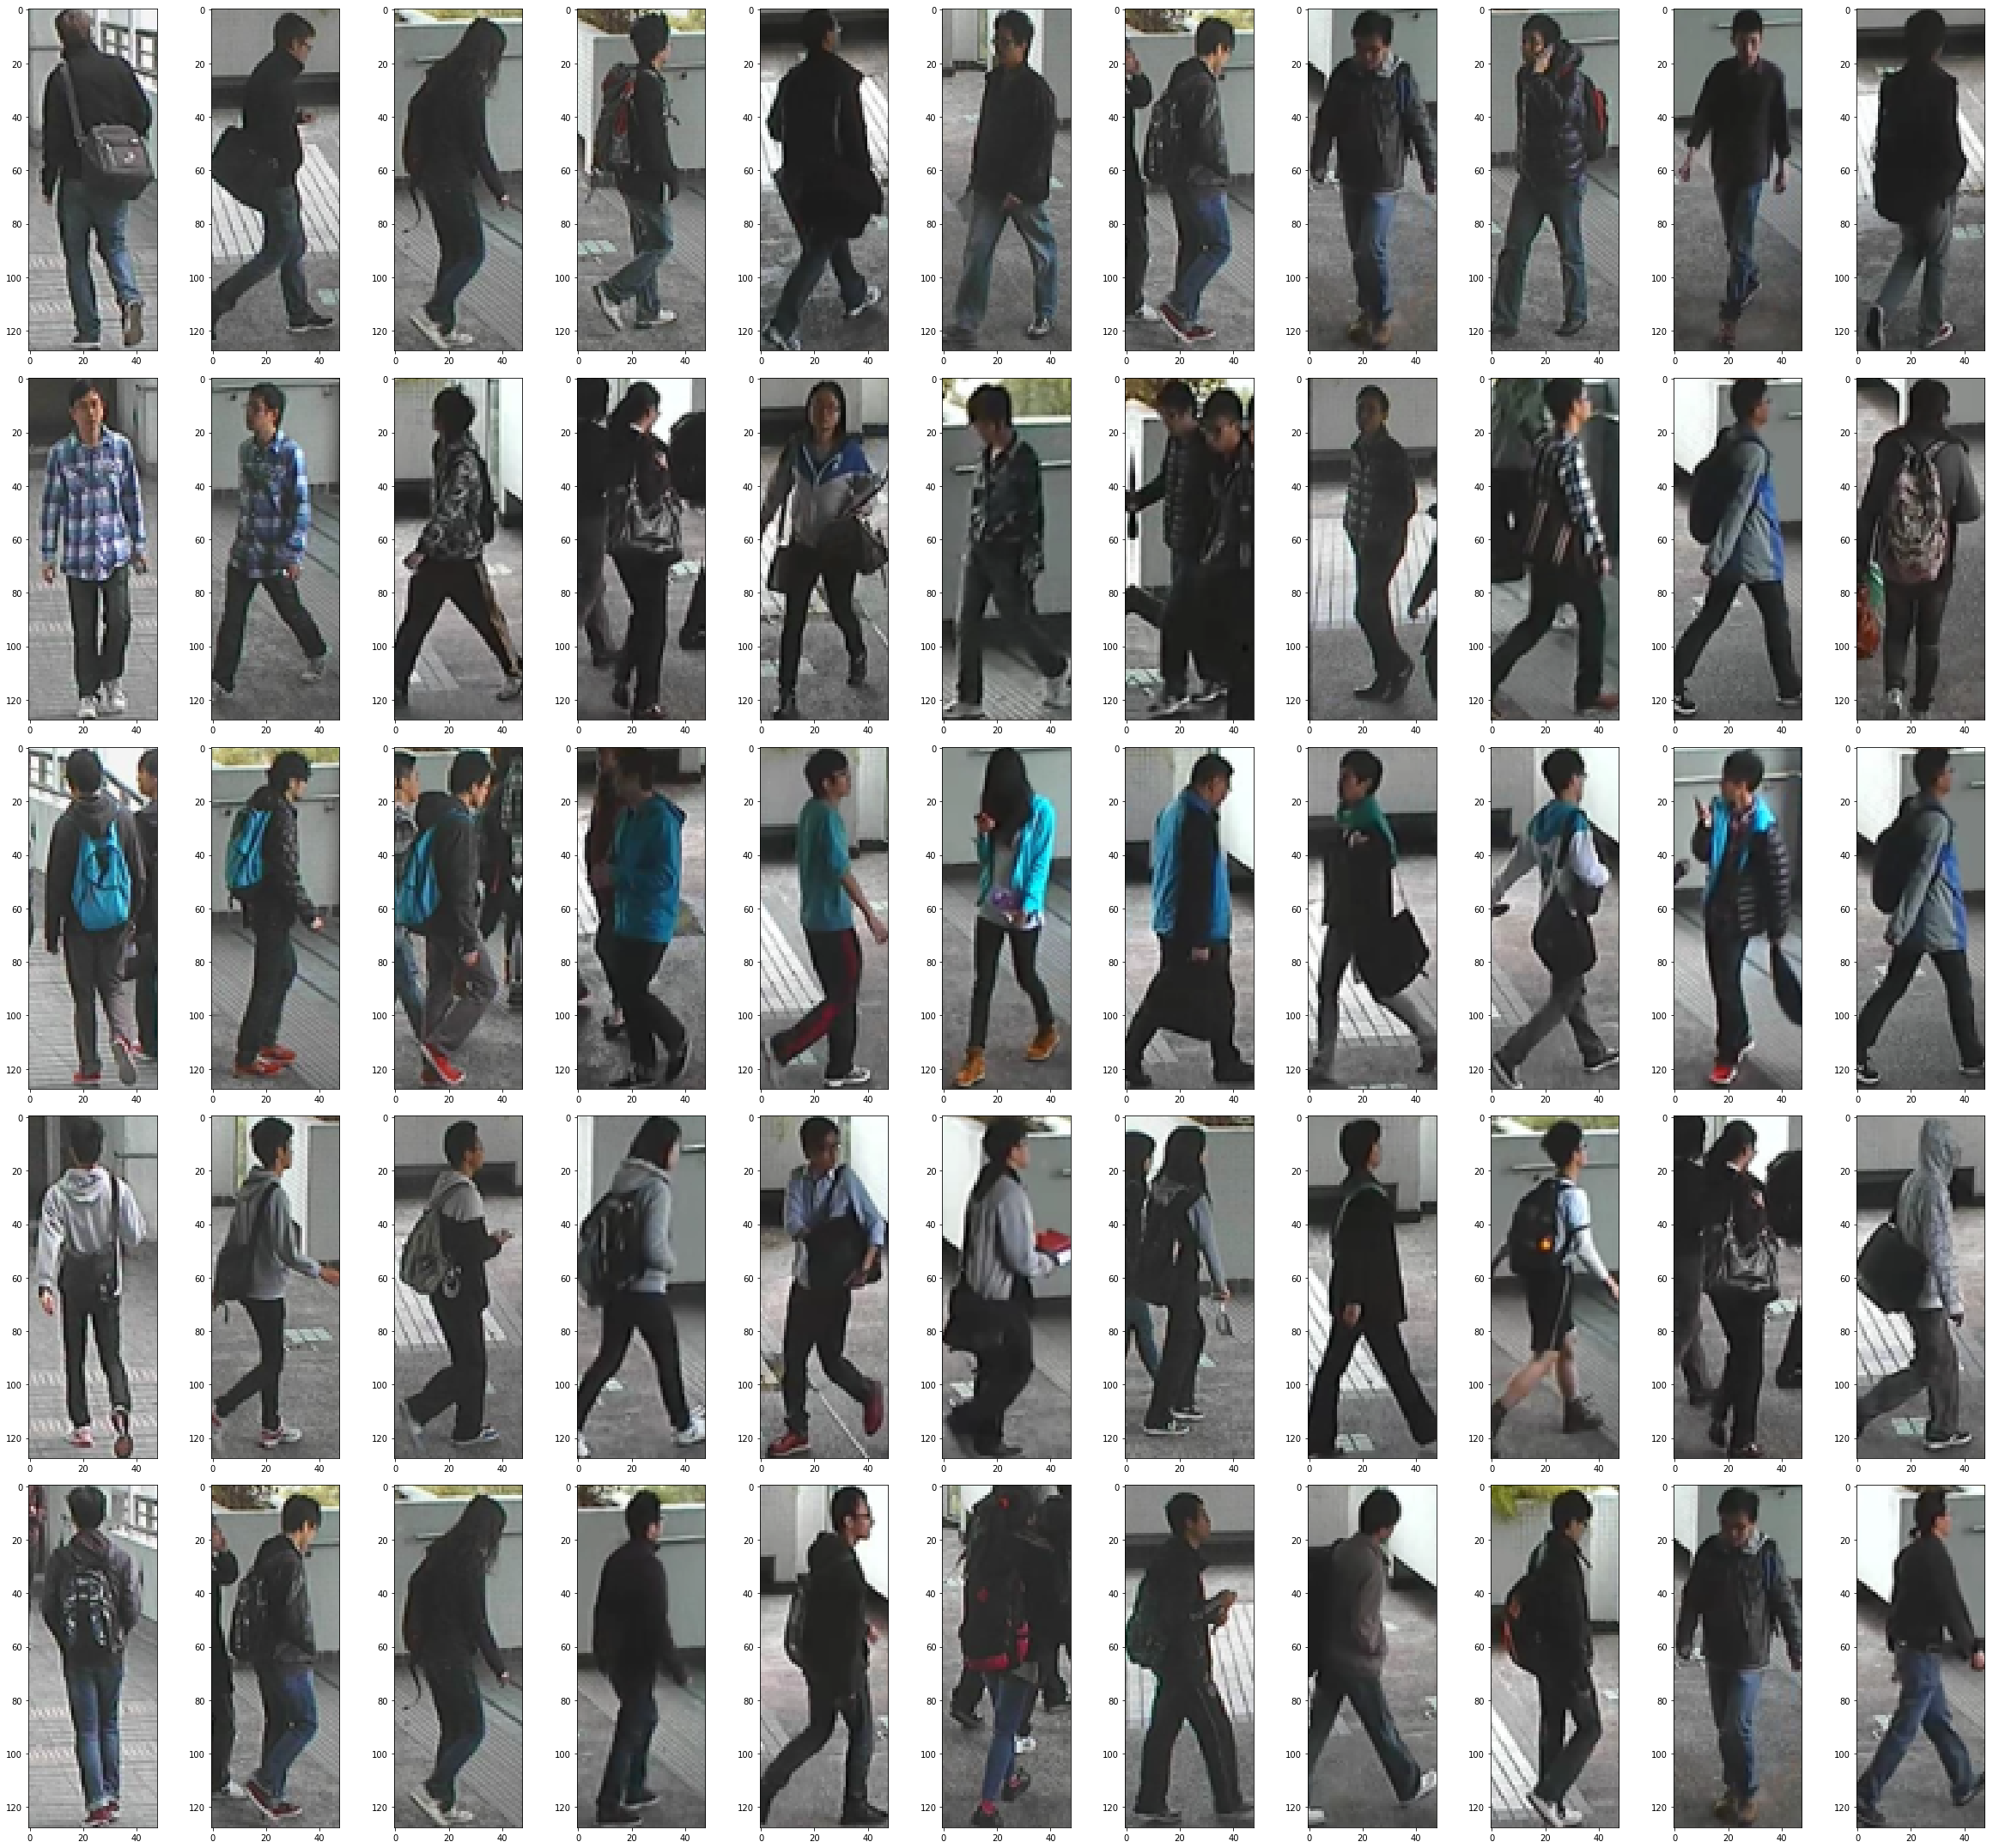

In [13]:
# Visualizando alguns rankings:
plt.figure(figsize=(33, 30))
for j in range(5):
    q_indice = querygal_split['query'][j]
    ranking = rankings[j, :]
    
    plt.subplot(5, 11, (j*11)+1)
    plt.imshow(X_querygal[q_indice])
    
    for i in range(10):
        plt.subplot(5, 11, (j*11)+i+2)
        plt.imshow(X_querygal[ranking[i]])
        
    plt.tight_layout()

In [14]:
query_pids = y_querygal[querygal_split['query']]
matched_pids = y_querygal[rankings]
print('Identidades de Query:')
print(query_pids[:20, np.newaxis])
print()
print('Identidades dos matches para cada Query (linha):')
print(matched_pids[:20])

Identidades de Query:
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]]

Identidades dos matches para cada Query (linha):
[[  0  16   7  60  20   4 229  23 455 175]
 [  1 366 326 169  98 207  32 127 170 149]
 [  6   2 107 472 483 460 362 335 443 170]
 [  3  14 290  92 309  30 216 348 326 283]
 [  4  16 343 474  39  19 352 329 229 456]
 [  0   5  21 455  16 453 459 229 148 226]
 [  6 443   2 362 483 472 107 296 386 335]
 [  7 226  23 353 413 352 329  69 453 229]
 [  8  94 480  29 444  89  35 149 341  17]
 [  9 154 143  27  14  51   1  41 135 258]
 [458  10  28 461  17  18 354 408  26  89]
 [ 11  30  40  35 102 361 121  36 236 285]
 [ 12  22  11  38  36  24  32  42  19  44]
 [ 13 119 252  74 113 392 401 121  29  37]
 [ 14 326 143 261 381 398 290 231 283   3]
 [ 24  19  15  30  32  40  11  42  34  35]
 [ 16  40 353 289 343 329   4  30 211 453]
 [ 22  17  48  44 468  36 315 313  67  12]
 [ 18  10 109  28 463 461 143 458

In [15]:
# rank-10 para esse split:
np.mean(np.sum(matched_pids[:, :10] == query_pids[:, np.newaxis], axis=1))

0.87654320987654322

In [16]:
def calculate_rank_k(k, query_pids, matched_pids):
    correct = 0
    # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
    # até a k-ésima posição
    for i, pid in enumerate(query_pids):
        if pid in matched_pids[i, :k]:
            correct += 1
            
    return correct / len(query_pids)


In [17]:
print('Rank-1: ', calculate_rank_k(1, query_pids, matched_pids))
print('Rank-5: ', calculate_rank_k(5, query_pids, matched_pids))
print('Rank-10: ', calculate_rank_k(10, query_pids, matched_pids))

Rank-1:  0.5534979423868313
Rank-5:  0.8106995884773662
Rank-10:  0.8765432098765432


# Cálculo do CMC

In [18]:
def calculate_cmc(y_querygal, cam_ids, features, N_splits=20, ranks=[1, 5, 10]):
    # Calcula as distâncias entre cada par de features
    distances = pairwise_squared_euclidian_distance(features, features)
    
    cmcs = {k: [] for k in ranks}

    
    # Para cada execução
    for n in range(N_splits):
        # Gera um split de Query e Galeria
        query_indices_by_cam = generate_query(y_querygal, cam_ids)
        
        for cam, indices in query_indices_by_cam.items():
            querygal_split = {
                'query': np.array(indices, dtype=np.intp),
                'gallery': get_gallery_for_cross_camera_search(cam_ids, cam_id=cam)
            }
            #if n < 2: print(querygal_split)
        
            rankings = querygal_split['gallery'][get_topk_results(distances, int(max(ranks)),
                                                              querygal_split).numpy()]
        
            query_pids = y_querygal[querygal_split['query']]
            matched_pids = y_querygal[rankings]
        
            for k in ranks:
                correct = 0
                # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
                # até a k-ésima posição
                for i, pid in enumerate(query_pids):
                    if pid in matched_pids[i, :k]:
                        correct += 1
            
                # média de acertos
                cmcs[k].append(correct / len(query_pids))

    for k, rank in cmcs.items():
        cmcs[k] = np.mean(rank)
    
    return cmcs

In [19]:
calculate_cmc(y_querygal, cam_ids, querygal_features, N_splits=20)

{1: 0.60781893004115228, 5: 0.81893004115226342, 10: 0.88523662551440341}

# Cálculo mAP

In [20]:
# Para cada execução
N_executions = 50

mAPs = []

for n in range(N_executions):
    # Gera um split de Query e Galeria
    query_indices_by_cam = generate_query(y_querygal, cam_ids)
    # Calcula o mAP (ver documentação da função para mais detalhes)
    mAPs.append(calculate_mAP(query_indices_by_cam, querygal_features, y_querygal, cam_ids))
    
print('mAP final: ', np.mean(mAPs))

mAP final:  0.640239174001
